In [1]:
import os 
if os.environ.get("preamble_run", None) is not None: 
    print("Not re-runnning preamble")
else: 
    %run -i ../preamble.py

Moved to /Users/einkleinerjakob/Documents/uniquark/ml/rl/project/RL-Hockey


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from src.mbpo.test_agent import get_latest_run_dir

In [3]:
# ENV = "HalfCheetah-v4"
ENV = "Hockey-One-v0"
RESULTS_DIR = f"outputs/mbpo/default/gym___{ENV}"
MODEL_DIR = get_latest_run_dir(RESULTS_DIR)


results = pd.read_csv(f"{MODEL_DIR}/results.csv")
model_train = pd.read_csv(f"{MODEL_DIR}/model_train.csv")
train = pd.read_csv(f"{MODEL_DIR}/train.csv")

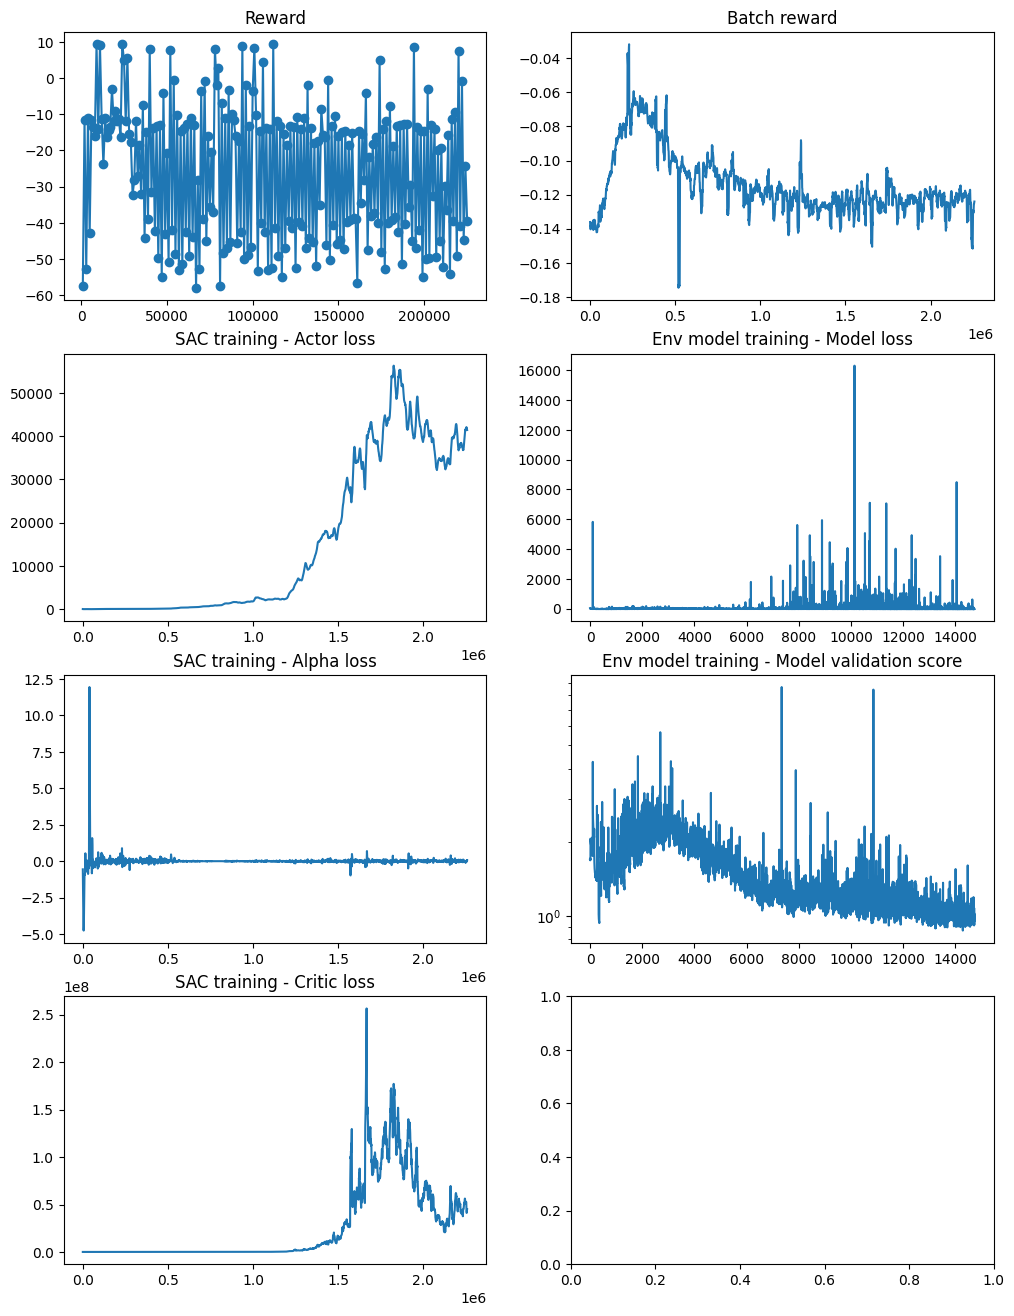

In [10]:
figs, axs = plt.subplots(4, 2, figsize=(12, 16))

rew_axis = axs[0, 0]
batch_rew_axis = axs[0, 1]
sac_axis0 = axs[1, 0]
sac_axis1 = axs[2, 0]
sac_axis2 = axs[3, 0]
env_model_axis0 = axs[1, 1]
env_model_axis1 = axs[2, 1]

rew_axis.set_title("Reward")
rew_axis.plot(results['env_step'], results['episode_reward'], marker="o")

env_model_axis0.set_title("Env model training - Model loss")
env_model_axis0.plot(model_train['step'], model_train['model_loss'], label="model_loss")
env_model_axis1.set_title("Env model training - Model validation score")
env_model_axis1.set_yscale("log")
env_model_axis1.plot(model_train['step'], model_train['model_val_score'], label="model_val_score")
# env_model_axis.legend()

sac_axis0.set_title("SAC training - Actor loss")
sac_axis0.plot(train['step'], train['actor_loss'], label="actor_loss")
sac_axis1.set_title("SAC training - Alpha loss")
sac_axis1.plot(train['step'], train['alpha_loss'], label="alpha_loss")
sac_axis2.set_title("SAC training - Critic loss")
sac_axis2.plot(train['step'], train['critic_loss'], label="critic_loss")
# sac_axis.legend()


batch_rew_axis.set_title("Batch reward")
batch_rew_axis.plot(train['step'], train['batch_reward'], label="batch_reward")